Below is the code for the constrained strongly quasar convex minimisation example.

In [33]:
import numpy as np
import time
import matplotlib.pyplot as plt

# ========= Problem definition (strongly quasar-convex example) =========

d = 100
rho = 20.0          # L1 radius for the constraint set {x : ||x||_1 <= rho}
rng = np.random.RandomState()

# a_i ~ U[0,1], b_i ~ U[-2.5,2.5] as in the paper [Quasar_convex, Sec. 6.1][file:73]
a_vec = rng.uniform(0.0, 1.0, size=d)
b_vec = rng.uniform(-2.5, 2.5, size=d)

def f_radial(t):
    # f(t) = t^2
    return t**2

def g_angular(theta):
    # theta in R^d with ||theta||_2 = 1
    # g(x) = sum_{i=1}^d (a_i sin(b_i x_i)^2 + 1)
    return np.sum(a_vec * np.sin(b_vec * theta)**2)+1

def h(x):
    """Strongly quasar-convex cost h(x)=f(||x||)*g(x/||x||)."""
    r = np.linalg.norm(x)
    if r == 0.0:
        # Any unit vector is fine, g>= d; value = f(0)*g(theta)=0.
        return 0.0
    theta = x / r
    return f_radial(r) * g_angular(theta)

def grad_h(x):
    """Euclidean gradient of h. Derived by chain rule on f(||x||) g(x/||x||)."""
    r = np.linalg.norm(x)
    if r == 0.0:
        return np.zeros_like(x)

    theta = x / r   # unit vector
    g_val = g_angular(theta)

    # grad_theta g(theta) in R^d
    # ∂/∂theta_i [ a_i sin(b_i theta_i)^2 + 1 ] = a_i * 2 sin(b_i θ_i) cos(b_i θ_i) * b_i
    # = a_i * b_i * sin(2 b_i θ_i)
    grad_g_theta = a_vec * b_vec * np.sin(2.0 * b_vec * theta)

    # gradient w.r.t. x:
    # ∇_x h = 2 r g(theta) θ + r^2 (I - θθ^T)/r * grad_g_theta
    #      = 2 r g(theta) θ + r (grad_g_theta - (grad_g_theta·θ) θ)
    proj = grad_g_theta - np.dot(grad_g_theta, theta) * theta
    return 2.0 * r * g_val * theta + r * proj

# ========= L1 projection =========

def proj_l1_ball(v, rho):
    """Euclidean projection of v onto {x : ||x||_1 <= rho}."""
    norm1 = np.sum(np.abs(v))
    if norm1 <= rho:
        return v.copy()
    # Soft-thresholding with data-dependent threshold
    u = np.abs(v)
    # sort u descending
    s = np.sort(u)[::-1]
    cssv = np.cumsum(s)
    rho_vec = (cssv - rho) / (np.arange(1, d+1))
    idx = np.where(s - rho_vec > 0)[0][-1]
    theta = rho_vec[idx]
    w = np.sign(v) * np.maximum(u - theta, 0.0)
    return w

# ========= Random-direction RM with projection =========

def grad(func,x,mu=0.05,t=10):
    fx = func(x)
    g_avg = np.zeros_like(x)
    for i in range(t):
        u = np.random.normal(0,1, size=len(x))
        g = (func(x+mu*u)-fx)/mu*u
        g_avg += g
    g_avg /= t
    return g_avg


def step(func,x,h,mu=0.05,t=10):
    grd = grad(func,x,mu,t)
    xx = x - h*grd
    return xx

def RM(func,x0,T,h = 0.001,mu=0.05,t=10):
    dim1 = len(x0)
    x=np.zeros((dim1,T+1))
    fvals = np.zeros(T+1)
    x[:,0]=x0.ravel()
    fvals[0] = func(x0)
    for k in range(T):
        x[:,k+1] =proj_l1_ball(step(func,x[:,k],h,mu,t),rho)
        fvals[k+1] = func(x[:,k+1])
    return x,fvals

# ========= Projected GD =========

def projected_GD(x0, T, lr):
    x = np.zeros((T+1, d))
    fvals = np.zeros(T+1)
    x[0] = proj_l1_ball(x0, rho)
    fvals[0] = h(x[0])
    for k in range(T):
        g = grad_h(x[k])
        x[k+1] = proj_l1_ball(x[k] - lr * g, rho)
        fvals[k+1] = h(x[k+1])
    return x, fvals

# ========= Run experiment and plot =========

T_rm = 10000
T_gd = 10000
h_rm = 1e-3
mu_rm = 1e-10
lr_gd = 1e-3
t_rm=1
MC = 10

f_rm_all = np.zeros((T_rm+1, MC))
f_gd_all = np.zeros((T_gd+1, MC))
t_rm_all = np.zeros(MC)
t_gd_all = np.zeros(MC)

for j in range(MC):
    x0 = rng.randn(d)

    # RM
    t0 = time.time()
    _, f_rm = RM(h, x0, T_rm, h_rm, mu_rm, t_rm)
    t_rm_all[j] = time.time() - t0
    f_rm_all[:, j] = f_rm

    # GD
    t0 = time.time()
    _, f_gd = projected_GD(x0, T_gd, lr_gd)
    t_gd_all[j] = time.time() - t0
    f_gd_all[:, j] = f_gd




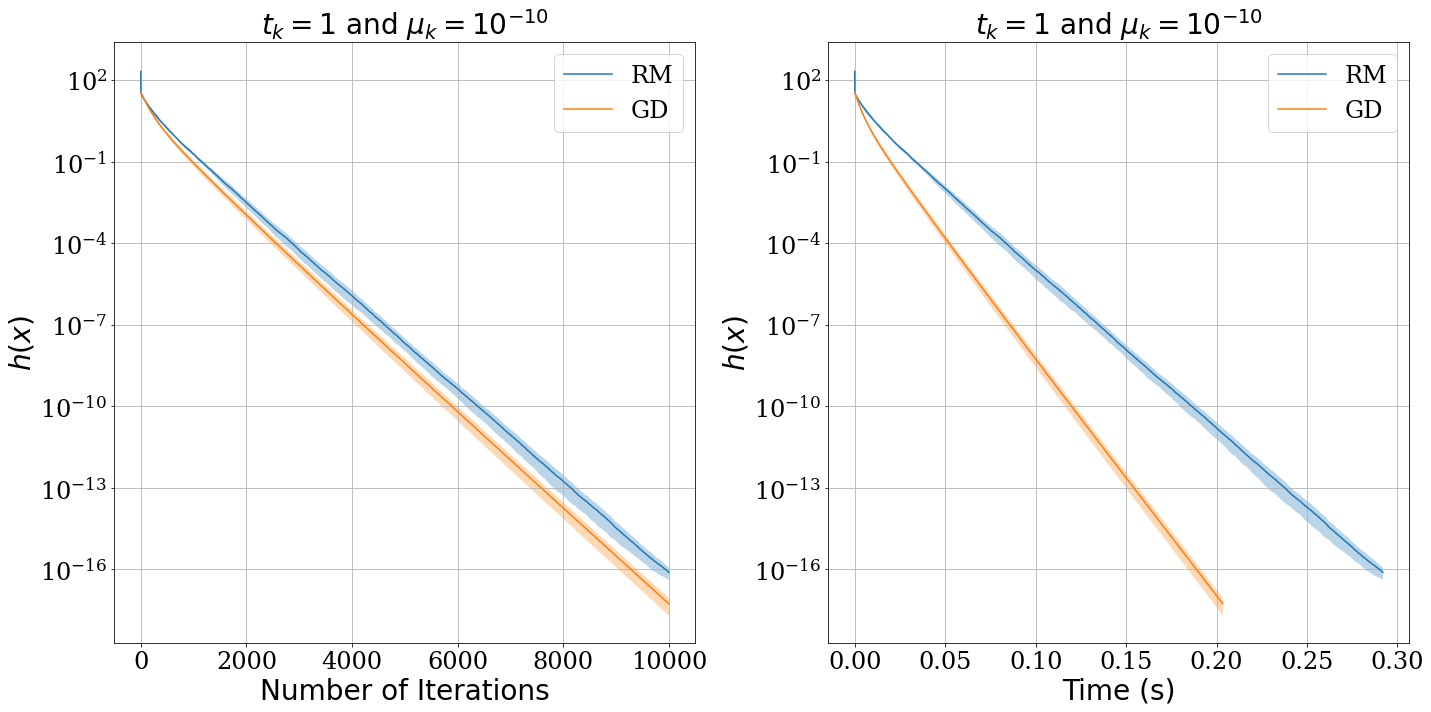

In [34]:
f_rm_mean = f_rm_all.mean(axis=1)
f_rm_std  = f_rm_all.std(axis=1)
f_gd_mean = f_gd_all.mean(axis=1)
f_gd_std  = f_gd_all.std(axis=1)

iters_rm = np.arange(T_rm+1)
iters_gd = np.arange(T_gd+1)

time_rm = np.linspace(0.0, t_rm_all.mean(), T_rm+1)
time_gd = np.linspace(0.0, t_gd_all.mean(), T_gd+1)

font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 28}
font1 = {'family': 'serif', 'size': 24}

plt.figure(figsize=(20,10))

# Function vs iterations
plt.subplot(1,2,1)
plt.xticks(fontname='serif', fontsize=24, color='black')
plt.yticks(fontname='serif', fontsize=24, color='black')
plt.plot(iters_rm, f_rm_mean, label='RM')
plt.plot(iters_gd, f_gd_mean, label='GD')
plt.fill_between(iters_rm, f_rm_mean - f_rm_std, f_rm_mean + f_rm_std, alpha=0.3)
plt.fill_between(iters_gd, f_gd_mean - f_gd_std, f_gd_mean + f_gd_std, alpha=0.3)
plt.yscale('log')
plt.xlabel('Number of Iterations', fontsize=28)
plt.ylabel(r'$h(x)$', fontdict=font)
plt.grid(True)
plt.legend(loc='best', prop=font1)
plt.title(r'$t_k=1$ and $\mu_k=10^{-10}$', fontsize=28)

# Function vs time
plt.subplot(1,2,2)
plt.xticks(fontname='serif', fontsize=24, color='black')
plt.yticks(fontname='serif', fontsize=24, color='black')
plt.plot(time_rm, f_rm_mean, label='RM')
plt.plot(time_gd, f_gd_mean, label='GD')
plt.fill_between(time_rm, f_rm_mean - f_rm_std, f_rm_mean + f_rm_std, alpha=0.3)
plt.fill_between(time_gd, f_gd_mean - f_gd_std, f_gd_mean + f_gd_std, alpha=0.3)
plt.yscale('log')
plt.xlabel('Time (s)', fontsize=28)
plt.ylabel(r'$h(x)$', fontdict=font)
plt.grid(True)
plt.legend(loc='best', prop=font1)
plt.title(r'$t_k=1$ and $\mu_k=10^{-10}$', fontsize=28)

plt.tight_layout()
plt.savefig('csqc2.pdf', format='pdf')